In [1]:
import logging
import tensorflow as tf


GPU_FROM = 3
GPU_TO = 4  

visible_devices = tf.config.get_visible_devices('GPU')
logging.info(f"Num GPUs visible:{len(visible_devices)}")
tf.config.set_visible_devices(visible_devices[GPU_FROM:GPU_TO],'GPU')

visible_devices = tf.config.get_visible_devices('GPU')
logging.info(f"Num GPUs to be used: {len(visible_devices)}")


from segmentation.model import SpaceSegmentationTransformer
from segmentation.model import LossWithVoids

data = tf.random.stateless_binomial(shape=(10000, 100), counts=1, probs=0.8, seed=[1997,1997])
train_frac = int(data.shape[0]*3/4)

train_ds, val_ds = tf.data.Dataset.from_tensor_slices(data[:train_frac]), tf.data.Dataset.from_tensor_slices(data[train_frac:])

def mapper(y):
    x = tf.strings.as_string(y+4)
    x = tf.strings.reduce_join(x, axis=-1)
    return tf.strings.regex_replace(x, "(45)", r"\1 ")

train_ds = train_ds.map(mapper)
val_ds = val_ds.map(mapper)

for f in train_ds.take(5):
    print(f)

2023-02-21 17:14:00.285123: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-21 17:14:00.438769: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-21 17:14:00.476157: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-21 17:14:01.122097: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

tf.Tensor(b'5555545 5555555445 5555445 545 5555545 555545 55555445 545 545 545 555545 5545 55555445 5555445 555545 55555555545 4', shape=(), dtype=string)
tf.Tensor(b'55545 5545 5545 45 555445 5445 45 5555555555545 545 555545 545 45 55545 55555545 55555545 545 45 45 445 45 55545 55555555', shape=(), dtype=string)
tf.Tensor(b'5555544445 45 55555545 45 5555445 555555545 555555555555555555545 555445 5555555545 5555545 5545 545 5445 45 45 444', shape=(), dtype=string)
tf.Tensor(b'545 555555445 555555545 555545 555555545 5555545 5555555555555445 45 45 555545 555545 5555555555555445 555555544', shape=(), dtype=string)
tf.Tensor(b'545 5555545 45 555555555445 554445 555545 555555555545 55555545 5545 555545 5555555445 55445 5555545 4445 5445 445 5', shape=(), dtype=string)


2023-02-21 17:14:02.145104: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-21 17:14:02.836058: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22296 MB memory:  -> device: 3, name: GeForce RTX 3090, pci bus id: 0000:d8:00.0, compute capability: 8.6


In [2]:
def generate_labels(text):
    max_chars = 100

    last_char = tf.strings.substr(text, max_chars, max_chars+1)
    text = tf.strings.substr(text,0, max_chars)
    text = tf.strings.lower(text)
    split_on_whitespace = tf.strings.strip(tf.strings.split(text))
    encoder_in = tf.strings.reduce_join(split_on_whitespace, axis=-1)
    
    space_indices = tf.math.cumsum(tf.strings.length(split_on_whitespace)) - 1 # subtract 1 to index from 0
    seq_len = space_indices[-1] + 1
    if not tf.strings.regex_full_match(last_char, " "):
        space_indices = space_indices[:-1]
    encoder_out = tf.ones((max_chars,))
    encoder_out = tf.concat([
        tf.ones((seq_len,)),
        tf.zeros((max_chars - seq_len,))
    ], axis=-1)
    encoder_out = tf.tensor_scatter_nd_update(
        encoder_out, 
        space_indices[...,tf.newaxis], # Expand dims to create a 'list' of indices
        tf.ones_like(space_indices, dtype=encoder_out.dtype)*2) 
    
    return (encoder_in, None), tf.cast(encoder_out-1, "float16")

train_ds = train_ds.map(generate_labels)
val_ds = val_ds.map(generate_labels)

for f in train_ds.take(1):
    print(f)

((<tf.Tensor: shape=(), dtype=string, numpy=b'55555455555555445555544554555555455555455555544554554554555554555455555544555554455555'>, None), <tf.Tensor: shape=(100,), dtype=float16, numpy=
array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  1.,  0.,
        0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  0.,  0., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1.], dtype=float16)>)


In [3]:
tokenizer = tf.keras.layers.TextVectorization(
    output_sequence_length=100,
    standardize="lower_and_strip_punctuation",
    split="character",
    output_mode="int",
)

tokenizer.adapt(train_ds.take(10).map(lambda x,y: x[0]))
tokenizer.get_vocabulary()

['', '[UNK]', '5', '4']

In [4]:
tokenizer("44444455555")

<tf.Tensor: shape=(100,), dtype=int64, numpy=
array([3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])>

In [5]:
model = SpaceSegmentationTransformer(
    num_layers=1,
    d_model=2,
    num_attention_heads=1,
    seq_len=100,
    dff=5,
    input_tokenizer=tokenizer,
    dropout_rate=0.1,
    num_classes = 2
)

In [6]:
from segmentation.metrics import SparseAccuracyWithIgnore
from segmentation.metrics import SparsePrecision
from segmentation.metrics import SparseRecall
from segmentation.metrics import SparseF1

model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, ignore_class=-1), # Why can I not ignore class 0?
    metrics=[
        SparseAccuracyWithIgnore(ignore_token=-1),
        SparsePrecision(class_id=1, name="space_precision"),
        SparseRecall(class_id=1, name="space_recall"),
        SparseF1(class_id=1, name="space_f1"),
        SparsePrecision(class_id=0, name="char_precision"),
        SparseRecall(class_id=0, name="char_recall"),
        SparseF1(class_id=0, name="char_f1"),
    ]
)


In [7]:
train_ds = train_ds.shuffle(100).batch(8)
val_ds = val_ds.batch(8)

history = model.fit(train_ds, validation_data=val_ds, epochs=10)
model.summary()

Epoch 1/10
 11/938 [..............................] - ETA: 15s - loss: 0.7097 - sparse_categorical_accuracy: 0.5007 - space_precision: 0.1310 - space_recall: 0.4843 - space_f1: 0.2062 - char_precision: 0.7282 - char_recall: 0.5037 - char_f1: 0.5955

2023-02-21 17:14:48.036834: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


938/938 [==============================] - 23s 21ms/step - loss: 0.4756 - sparse_categorical_accuracy: 0.8255 - space_precision: 0.1357 - space_recall: 0.0284 - space_f1: 0.0470 - char_precision: 0.7304 - char_recall: 0.9717 - char_f1: 0.8339 - val_loss: 0.4307 - val_sparse_categorical_accuracy: 0.8454 - val_space_precision: 0.0000e+00 - val_space_recall: 0.0000e+00 - val_space_f1: nan - val_char_precision: 0.7312 - val_char_recall: 1.0000 - val_char_f1: 0.8447
Epoch 2/10
938/938 [==============================] - 18s 19ms/step - loss: 0.4314 - sparse_categorical_accuracy: 0.8450 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.7306 - char_recall: 1.0000 - char_f1: 0.8444 - val_loss: 0.4307 - val_sparse_categorical_accuracy: 0.8454 - val_space_precision: 0.0000e+00 - val_space_recall: 0.0000e+00 - val_space_f1: nan - val_char_precision: 0.7312 - val_char_recall: 1.0000 - val_char_f1: 0.8447
Epoch 3/10
938/938 [==============================] 

In [8]:
model.evaluate(val_ds)

313/313 [==============================] - 3s 11ms/step - loss: 0.4307 - sparse_categorical_accuracy: 0.8454 - space_precision: 0.0000e+00 - space_recall: 0.0000e+00 - space_f1: nan - char_precision: 0.7312 - char_recall: 1.0000 - char_f1: 0.8447


[0.43066439032554626,
 0.8454476594924927,
 0.0,
 0.0,
 nan,
 0.7312039732933044,
 1.0,
 0.8447346091270447]

In [9]:
preds = model([("5554445", "55544455554445", "5454545454545454"),(None,None, None)])
preds, tf.argmax(preds, axis=-1)

(<tf.Tensor: shape=(3, 100, 2), dtype=float32, numpy=
 array([[[0.84615004, 0.15384997],
         [0.8437454 , 0.15625459],
         [0.8437454 , 0.15625459],
         [0.8437454 , 0.15625459],
         [0.84615004, 0.15384997],
         [0.84615004, 0.15384997],
         [0.84615004, 0.15384997],
         [0.8437454 , 0.15625459],
         [0.8437454 , 0.15625459],
         [0.8437454 , 0.15625459],
         [0.8437454 , 0.15625459],
         [0.84615004, 0.15384997],
         [0.84615004, 0.15384997],
         [0.84615004, 0.15384997],
         [0.8437454 , 0.15625459],
         [0.8437454 , 0.15625459],
         [0.8437454 , 0.15625459],
         [0.84615004, 0.15384997],
         [0.84615004, 0.15384997],
         [0.84615004, 0.15384997],
         [0.8437454 , 0.15625459],
         [0.8437454 , 0.15625459],
         [0.8437454 , 0.15625459],
         [0.84615004, 0.15384997],
         [0.84615004, 0.15384997],
         [0.84615004, 0.15384997],
         [0.8437454 , 0.15625459],
 

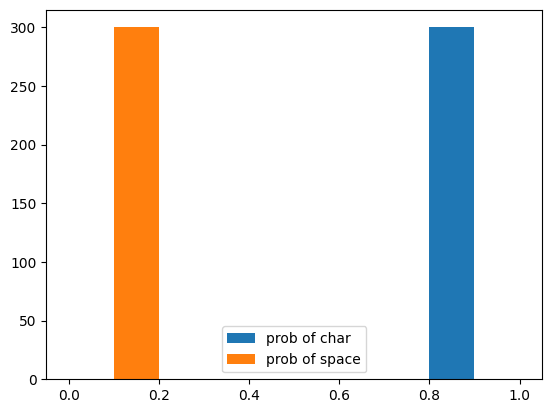

In [20]:
import matplotlib.pyplot as plt

plt.hist(tf.reshape(preds, (-1, 2))[:,0], label="prob of char", range=(0,1))
plt.hist(tf.reshape(preds, (-1, 2))[:,1], label="prob of space", range=(0,1))
plt.legend()